# Food Prices of the Yemen country released by OCHA 

Link to Food Prices data released by OCHA (The Humanitarian Data Exchange): https://data.humdata.org/dataset/wfp-food-prices-for-yemen

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd
plt.style.use("ggplot")

In [2]:
df = pd.read_csv("wfp_food_prices_yemen.csv", header = 1)
df.head()

,#date,#item+name,#item+unit,#item+type,#value,#currency,#country+name,#adm1+name,#adm1+code,#name+market,Unnamed: 10,#item+code,Unnamed: 12,Unnamed: 13,#item+type+code,#meta+id,Unnamed: 16
0,2016-07-15,Wheat flour - Retail,KG,cereals and tubers,172.0,YER,Yemen,Abyan,3407,Zungubar City,1940,58,15,5,1,1940_58_15_5,NaN
1,2016-08-15,Wheat flour - Retail,KG,cereals and tubers,150.0,YER,Yemen,Abyan,3407,Zungubar City,1940,58,15,5,1,1940_58_15_5,NaN
2,2016-09-15,Wheat flour - Retail,KG,cereals and tubers,150.0,YER,Yemen,Abyan,3407,Zungubar City,1940,58,15,5,1,1940_58_15_5,NaN
3,2016-10-15,Wheat flour - Retail,KG,cereals and tubers,153.0,YER,Yemen,Abyan,3407,Zungubar City,1940,58,15,5,1,1940_58_15_5,NaN
4,2016-11-15,Wheat flour - Retail,KG,cereals and tubers,164.0,YER,Yemen,Abyan,3407,Zungubar City,1940,58,15,5,1,1940_58_15_5,NaN


ATTENTION: some items in the dataframe have NaN values in correspondence of temporal information.

### Brief keys description (more relevant)

- *#date*: temporal information.
- *#item+name*: names of the products considered in this dataset.
- *#item+type*: names of the aggregation of products described in the #item+name item (#item+type is a subset of #item+name).
- *#item+unit*: the reference units at which the prices are set for the productsn (depending on the products: 'KG', 'Unit', 'L', 'Day', '18 KG', 'Head', 'USD/LCU', '50 KG').
- *#currency*: the currency of the prices (YER currency for all the products).
- *#value*: the value of the prices of the products.
- *#country+name*: name of the country considered in the survey (only Yemen in this case).
- *#adm1+name*: name of the provinces/regions of the country considered in the survey. 
- *#name+market*: name of the markets of the provinces where the prices have been collected.

### Preprocessing

In [3]:
# Keep only some features/items and raname them.
df = df[["#date", "#item+name", "#item+unit", "#item+type", "#value", "#adm1+name", "#name+market"]]
df.rename(columns = {"#date": "Datetime", "#name+market": "Market name", "#item+name": "Item name", "#item+type": "Item type", "#item+unit": "Item unit", "#value": "Value", "#adm1+name": "AdminStrata"}, inplace = True)
df.head()

,Datetime,Item name,Item unit,Item type,Value,AdminStrata,Market name
0,2016-07-15,Wheat flour - Retail,KG,cereals and tubers,172.0,Abyan,Zungubar City
1,2016-08-15,Wheat flour - Retail,KG,cereals and tubers,150.0,Abyan,Zungubar City
2,2016-09-15,Wheat flour - Retail,KG,cereals and tubers,150.0,Abyan,Zungubar City
3,2016-10-15,Wheat flour - Retail,KG,cereals and tubers,153.0,Abyan,Zungubar City
4,2016-11-15,Wheat flour - Retail,KG,cereals and tubers,164.0,Abyan,Zungubar City


In [4]:
# We consider the time-series corresponding to the 'Item name' ('Item type' is a subset of this one). 
# Each 'Item name' has an unique value of the 'Item unit', but not the 'Oil (vegetable) - Retail' item that has two values: L and KG. We convert all to L.
def oil_kg_to_litre(row):
    a = row["Item name"] 
    b = row["Item unit"]
    c = row["Value"]
    if row["Item name"] == "Oil (vegetable) - Retail" and row["Item name"] != "L":
        c = row["Value"]*0.92
        b = "L"
    return pd.Series([a, b, c])

df[["Item name", "Item unit", "Value"]] = df.apply(oil_kg_to_litre, axis = 1)

In [5]:
# Convert the item 'Datetime' in the same format of that of FCS and rCSI indicators (end of the month).
def datetime(date):
    y, m, d = date.split("-")
    d = str(pd.Period(date).days_in_month)
    date = pd.to_datetime(y + m + d)
    return date


df["Datetime"] = df["Datetime"].apply(datetime)
df.sort_values("Datetime", ascending = True, inplace = True) # Sort on datetime.
df.head()

,Datetime,Item name,Item unit,Item type,Value,AdminStrata,Market name
24003,2009-03-31,Wheat - Retail,KG,cereals and tubers,95.0,Taizz,Taizz City
5038,2009-03-31,Wheat - Retail,KG,cereals and tubers,100.0,Al Hudaydah,Al Hudaydah City (Hodieda)
20376,2009-03-31,Wheat flour - Retail,KG,cereals and tubers,120.0,Sa'ada,Sa'ada City
4572,2009-03-31,Wheat flour - Retail,KG,cereals and tubers,120.0,Al Hudaydah,Al Hudaydah City (Hodieda)
1896,2009-03-31,Wheat flour - Retail,KG,cereals and tubers,110.0,Aden,Aden City


In [6]:
# I mean the values of the same item name, the same datetime and the same AdminStrata but with different market places.
df = df.groupby(["Datetime", "Item name", "Item unit", "AdminStrata"])["Value"].mean().reset_index()
df.head()

,Datetime,Item name,Item unit,AdminStrata,Value
0,2009-03-31,Wheat - Retail,KG,Aden,100.0
1,2009-03-31,Wheat - Retail,KG,Al Hudaydah,100.0
2,2009-03-31,Wheat - Retail,KG,Amanat Al Asimah,90.0
3,2009-03-31,Wheat - Retail,KG,Hadramaut,100.0
4,2009-03-31,Wheat - Retail,KG,Sa'ada,110.0


#### Creation of an accurate datetime feature

I add the missing datetime values for every AdminStrata key of every country in order to show the real timeseries graphs (based on the own max and min datetime values).

In [7]:
df = df.groupby(["AdminStrata", "Item name"]).apply(lambda group: group.set_index("Datetime").resample("M").mean()).reset_index()
df.reset_index(drop = True, inplace = True)
df.head()

,AdminStrata,Item name,Datetime,Value
0,Abyan,Beans (kidney red) - Retail,2016-07-31,478.0
1,Abyan,Beans (kidney red) - Retail,2016-08-31,400.0
2,Abyan,Beans (kidney red) - Retail,2016-09-30,475.0
3,Abyan,Beans (kidney red) - Retail,2016-10-31,500.0
4,Abyan,Beans (kidney red) - Retail,2016-11-30,500.0


In [8]:
# Rename the name of some AdminStrata according to the fcs and rcsi names of the AdminStrata.
df.replace(["Al Dhale'e", "Sa'ada", "Amanat Al Asimah"], ["Ad Dali", "Sa'dah", "Sana'a City"], inplace = True)

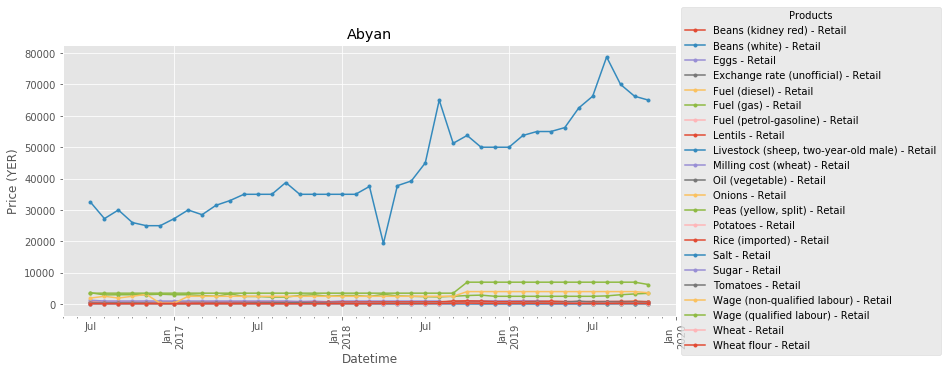

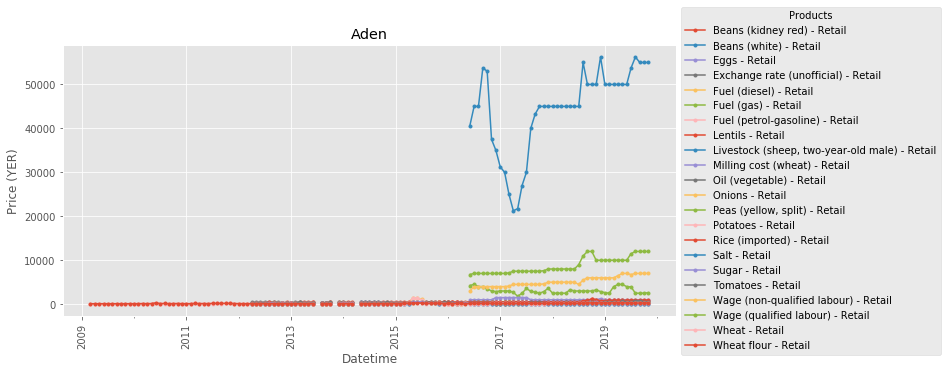

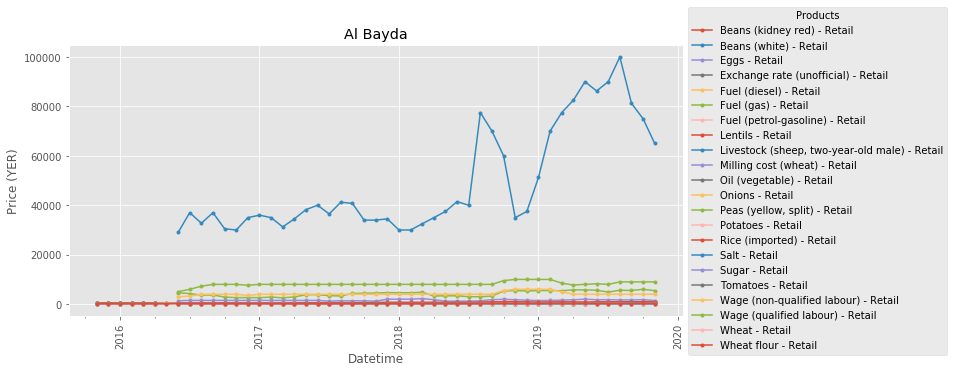

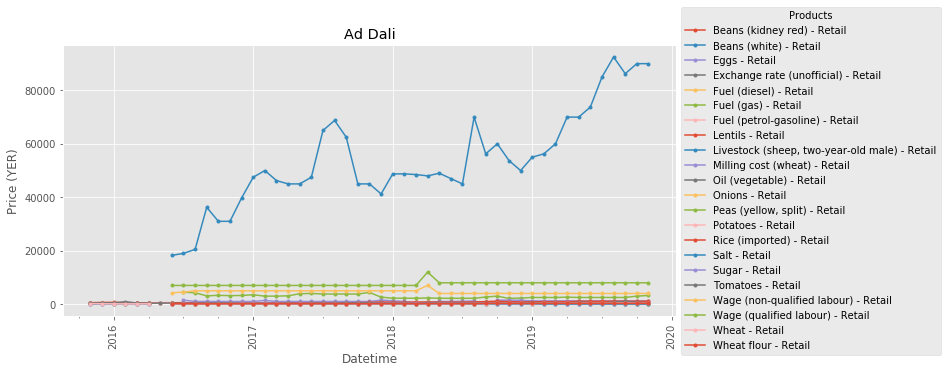

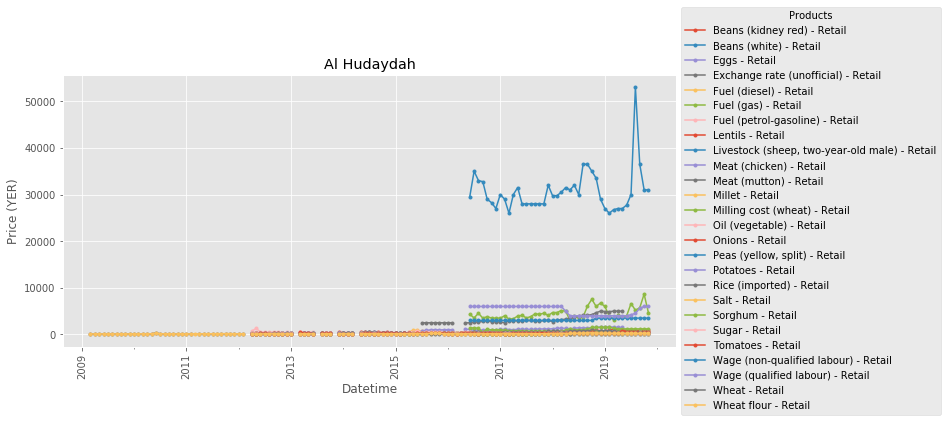

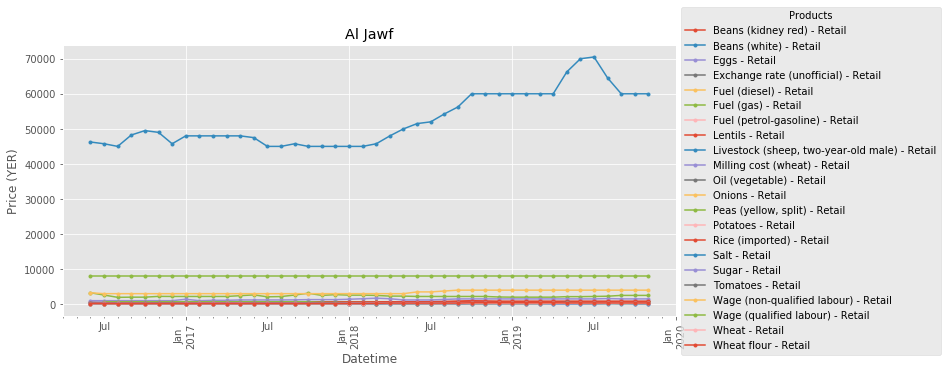

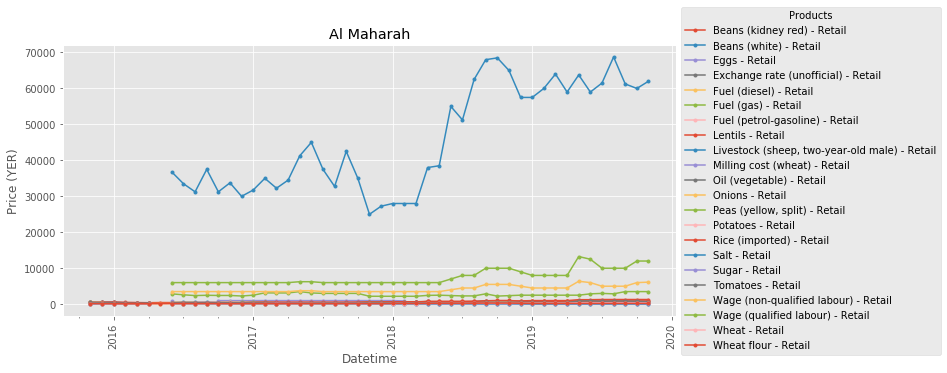

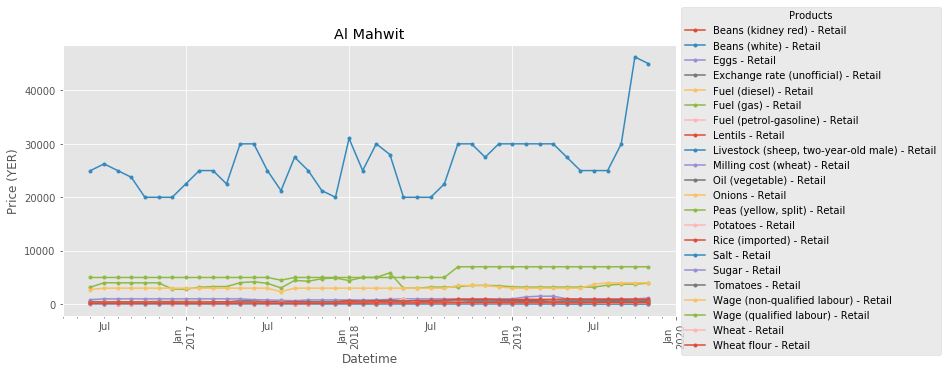

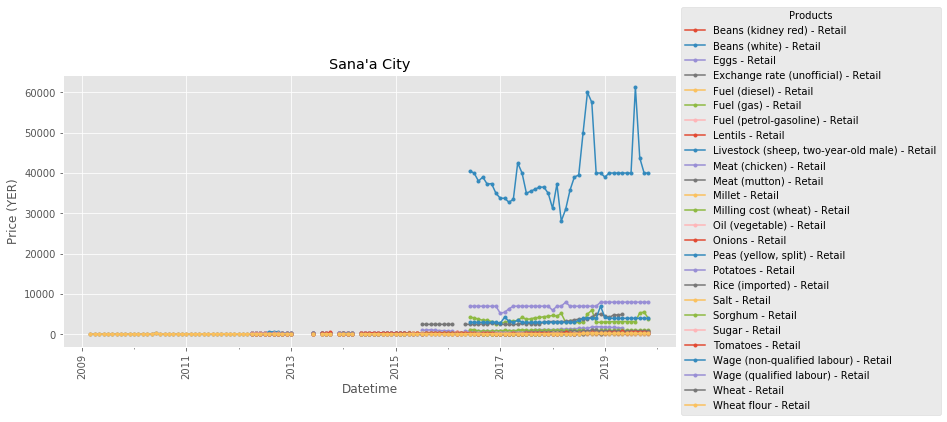

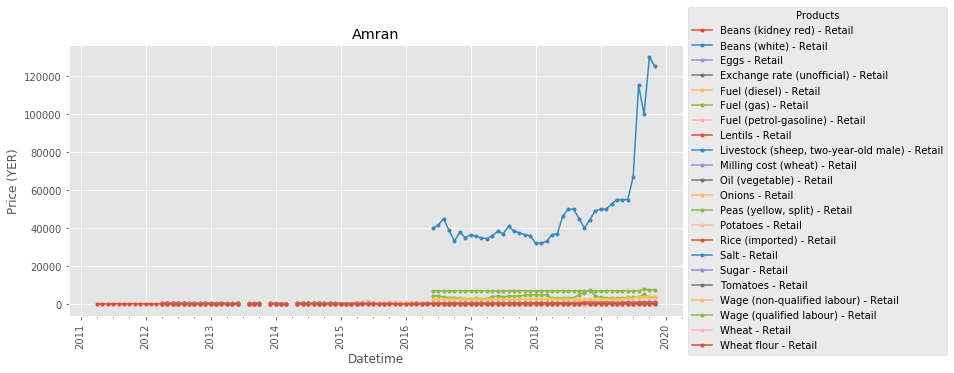

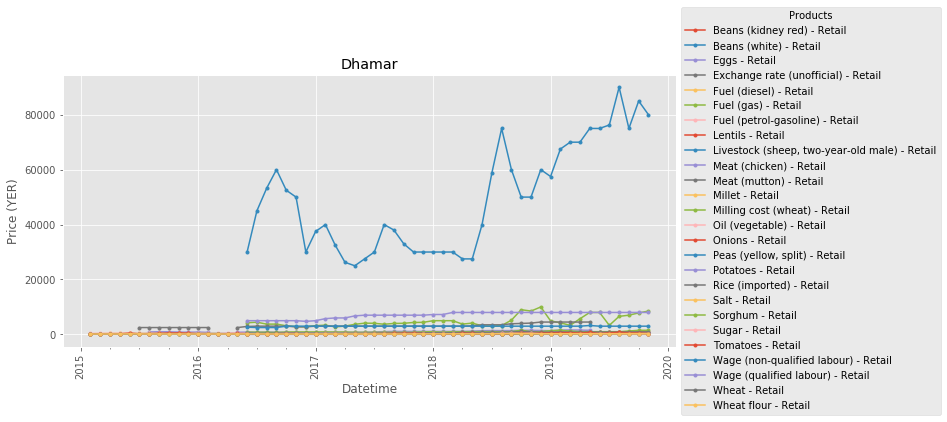

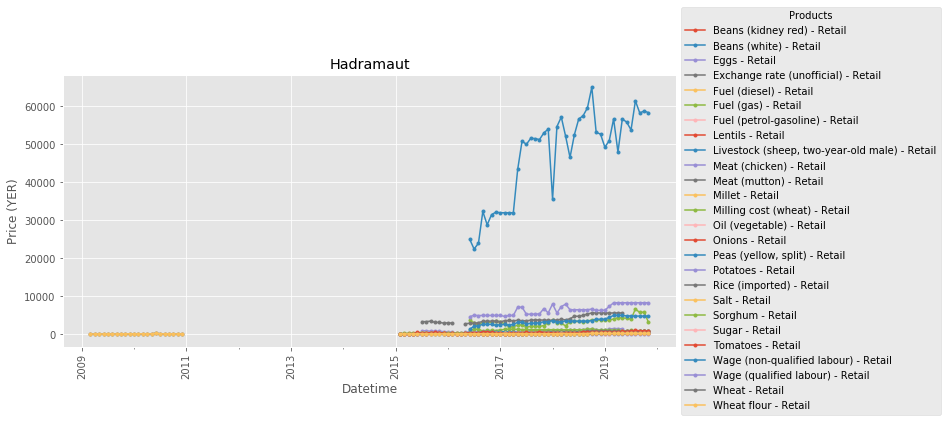

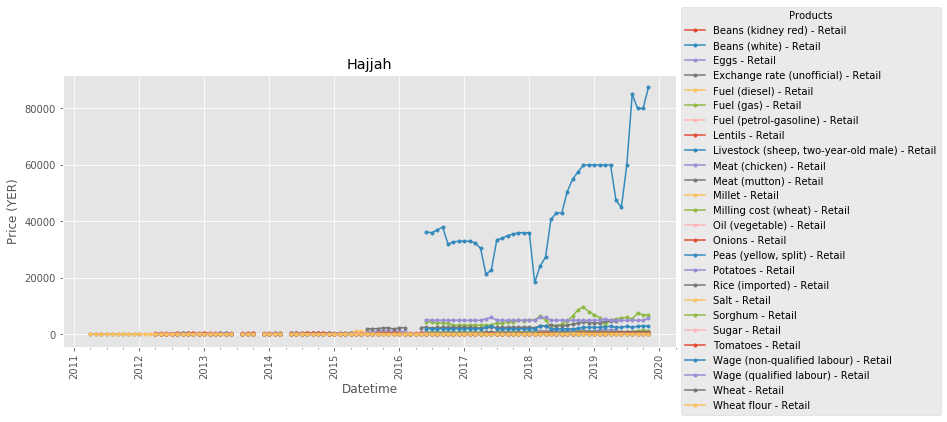

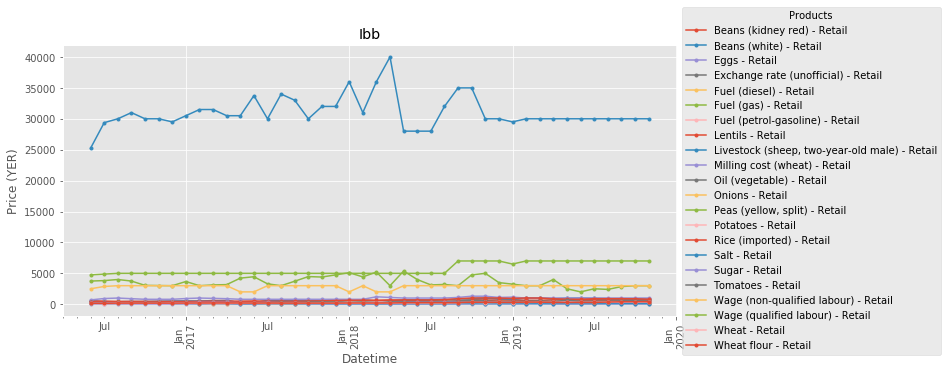

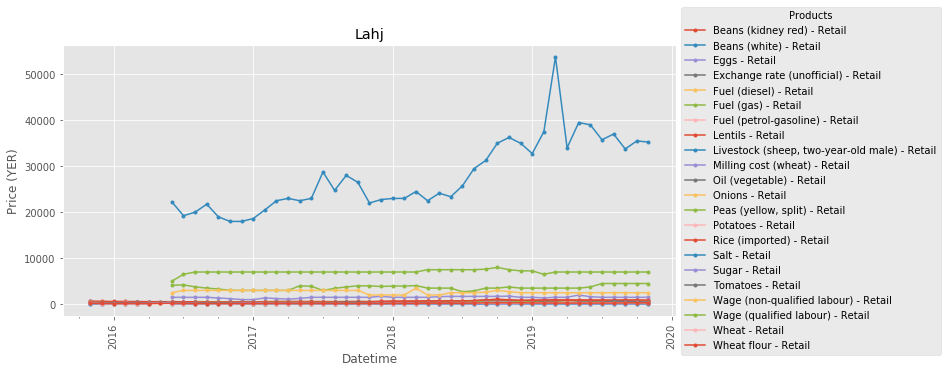

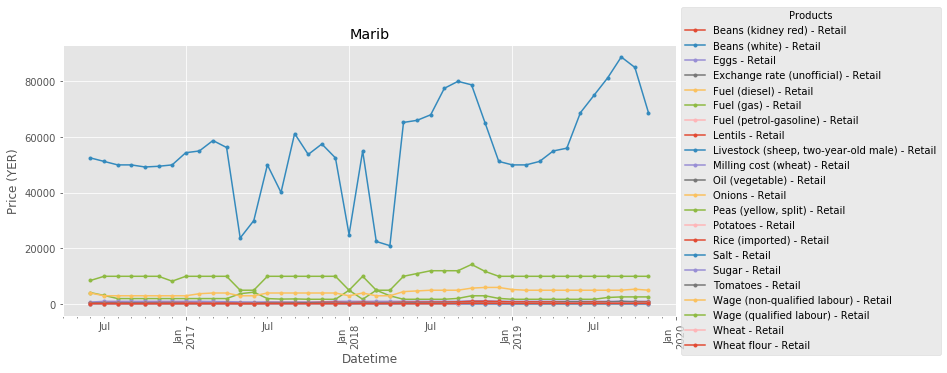

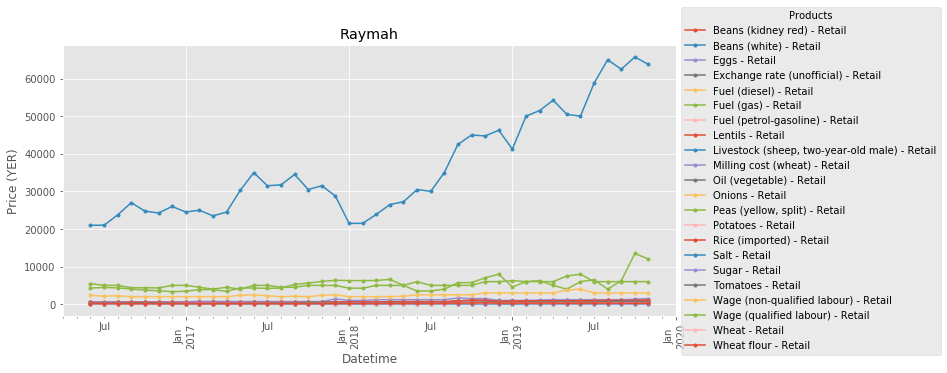

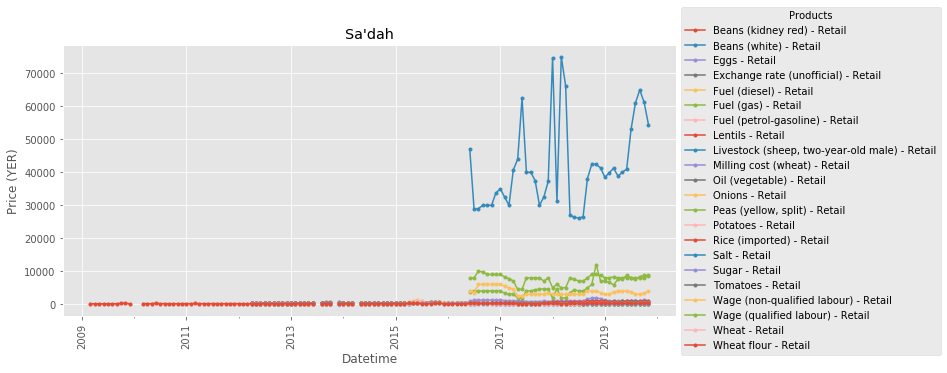

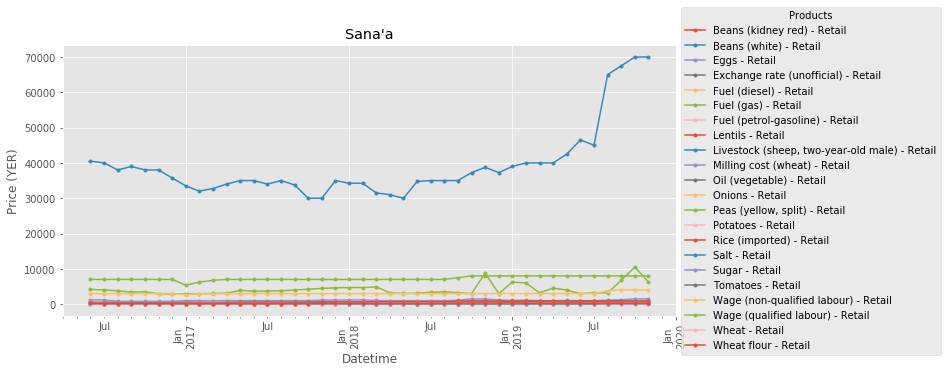

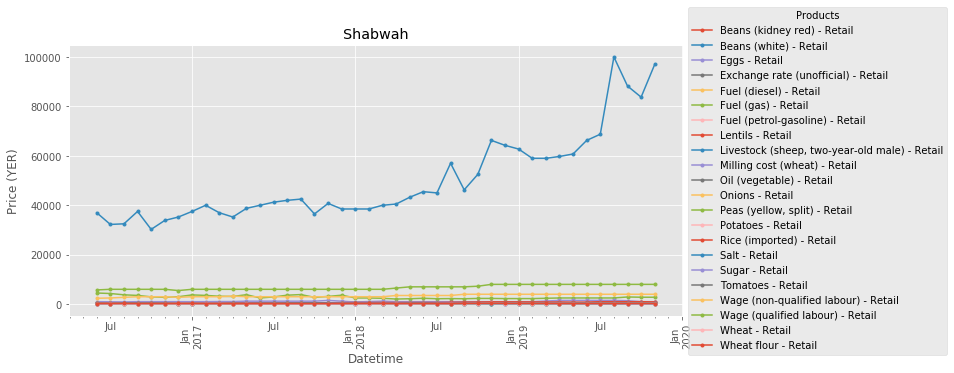

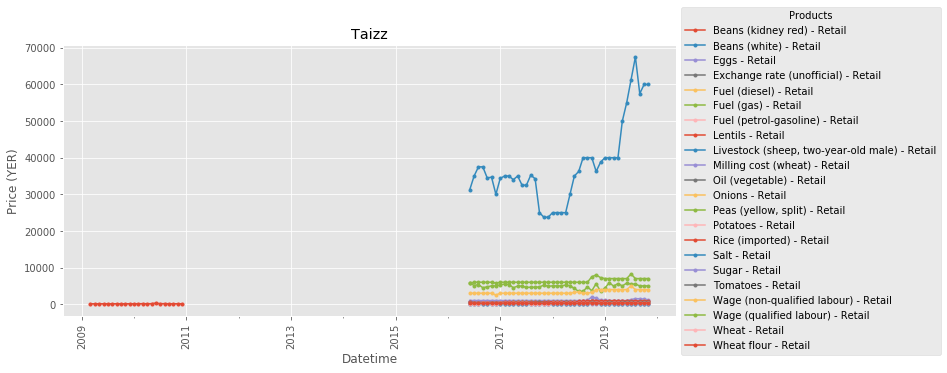

In [9]:
for AdminStrata in df.AdminStrata.unique():
    sub_df = df[df.AdminStrata == AdminStrata]
    f = plt.figure(figsize = (11, 5))
    plt.title(AdminStrata, color = "black")
    sub_df.groupby(["Datetime", "Item name"]).mean()["Value"].unstack().plot(ax = f.gca(), style = ".-")
    plt.legend(title = "Products", loc = "center left", bbox_to_anchor = (1.0, 0.5))
    plt.ylabel("Price (YER)")
    plt.xticks(rotation = 90)
    plt.autoscale()
    #plt.savefig(country + '.png')
    plt.show()

### Get Food Price time-series according to timestamp of FCS and rCSI time-series

In [10]:
# Food Consumption Score (FCS/FCG).
fcs = pd.read_excel("../Food Consumption Score (FCS)/wfp_fcs_yemen.xlsx", index_col = 0, parse_dates = True)
fcs.columns.name = "AdminStrata"

In [11]:
price = pd.DataFrame([])
for AdminStrata in df.AdminStrata.unique():
    ts_price = df[df.AdminStrata == AdminStrata].groupby(["Datetime", "Item name"]).mean()["Value"].unstack()
    # Greater than the start date and smaller than the end date using as the first and the last index of the fcs and rcsi time-series.
    mask = (ts_price.index >= fcs.index[0]) & (ts_price.index <= fcs.index[-1])
    ts_price = ts_price.loc[mask]
    price = pd.concat([price, ts_price.add_suffix("_" + AdminStrata)], axis = 1)
    
price.columns.name = "AdminStrata"
price.head()

AdminStrata,Beans (kidney red) - Retail_Abyan,Beans (white) - Retail_Abyan,Eggs - Retail_Abyan,Exchange rate (unofficial) - Retail_Abyan,Fuel (diesel) - Retail_Abyan,Fuel (gas) - Retail_Abyan,Fuel (petrol-gasoline) - Retail_Abyan,Lentils - Retail_Abyan,"Livestock (sheep, two-year-old male) - Retail_Abyan",Milling cost (wheat) - Retail_Abyan,...,"Peas (yellow, split) - Retail_Taizz",Potatoes - Retail_Taizz,Rice (imported) - Retail_Taizz,Salt - Retail_Taizz,Sugar - Retail_Taizz,Tomatoes - Retail_Taizz,Wage (non-qualified labour) - Retail_Taizz,Wage (qualified labour) - Retail_Taizz,Wheat - Retail_Taizz,Wheat flour - Retail_Taizz
Datetime,,,,,,,,,,,,,,,,,,,,,
2015-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


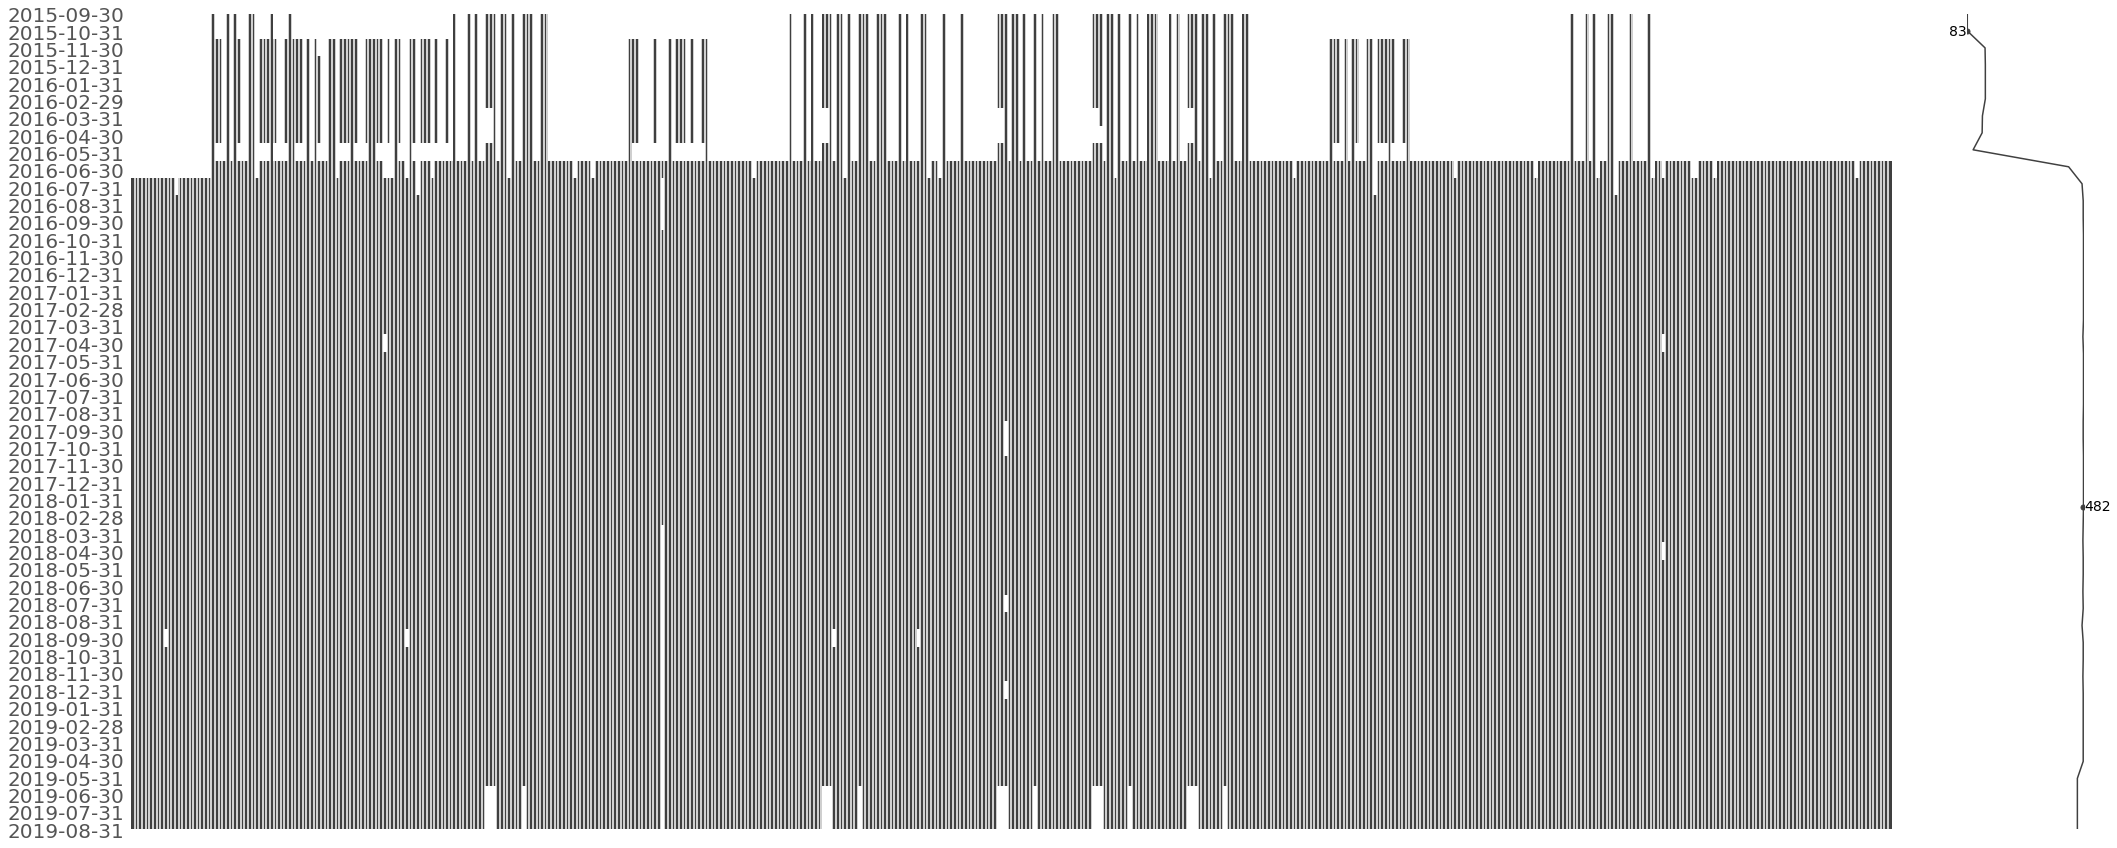

In [12]:
# Visualization of the missing values of the AdminStrata of the Yemen country of different products.
# Citation package: Bilogur, (2018). Missingno: a missing data visualization suite. Journal of Open Source Software, 3(22), 547, https://doi.org/10.21105/joss.00547
miss = msno.matrix(price.set_index(pd.period_range(price.index[0], price.index[-1], freq = "M")), freq = "M", figsize = (35, 15))

In [13]:
price.interpolate(method = "linear", limit = 4, inplace = True)
price.head()

AdminStrata,Beans (kidney red) - Retail_Abyan,Beans (white) - Retail_Abyan,Eggs - Retail_Abyan,Exchange rate (unofficial) - Retail_Abyan,Fuel (diesel) - Retail_Abyan,Fuel (gas) - Retail_Abyan,Fuel (petrol-gasoline) - Retail_Abyan,Lentils - Retail_Abyan,"Livestock (sheep, two-year-old male) - Retail_Abyan",Milling cost (wheat) - Retail_Abyan,...,"Peas (yellow, split) - Retail_Taizz",Potatoes - Retail_Taizz,Rice (imported) - Retail_Taizz,Salt - Retail_Taizz,Sugar - Retail_Taizz,Tomatoes - Retail_Taizz,Wage (non-qualified labour) - Retail_Taizz,Wage (qualified labour) - Retail_Taizz,Wheat - Retail_Taizz,Wheat flour - Retail_Taizz
Datetime,,,,,,,,,,,,,,,,,,,,,
2015-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


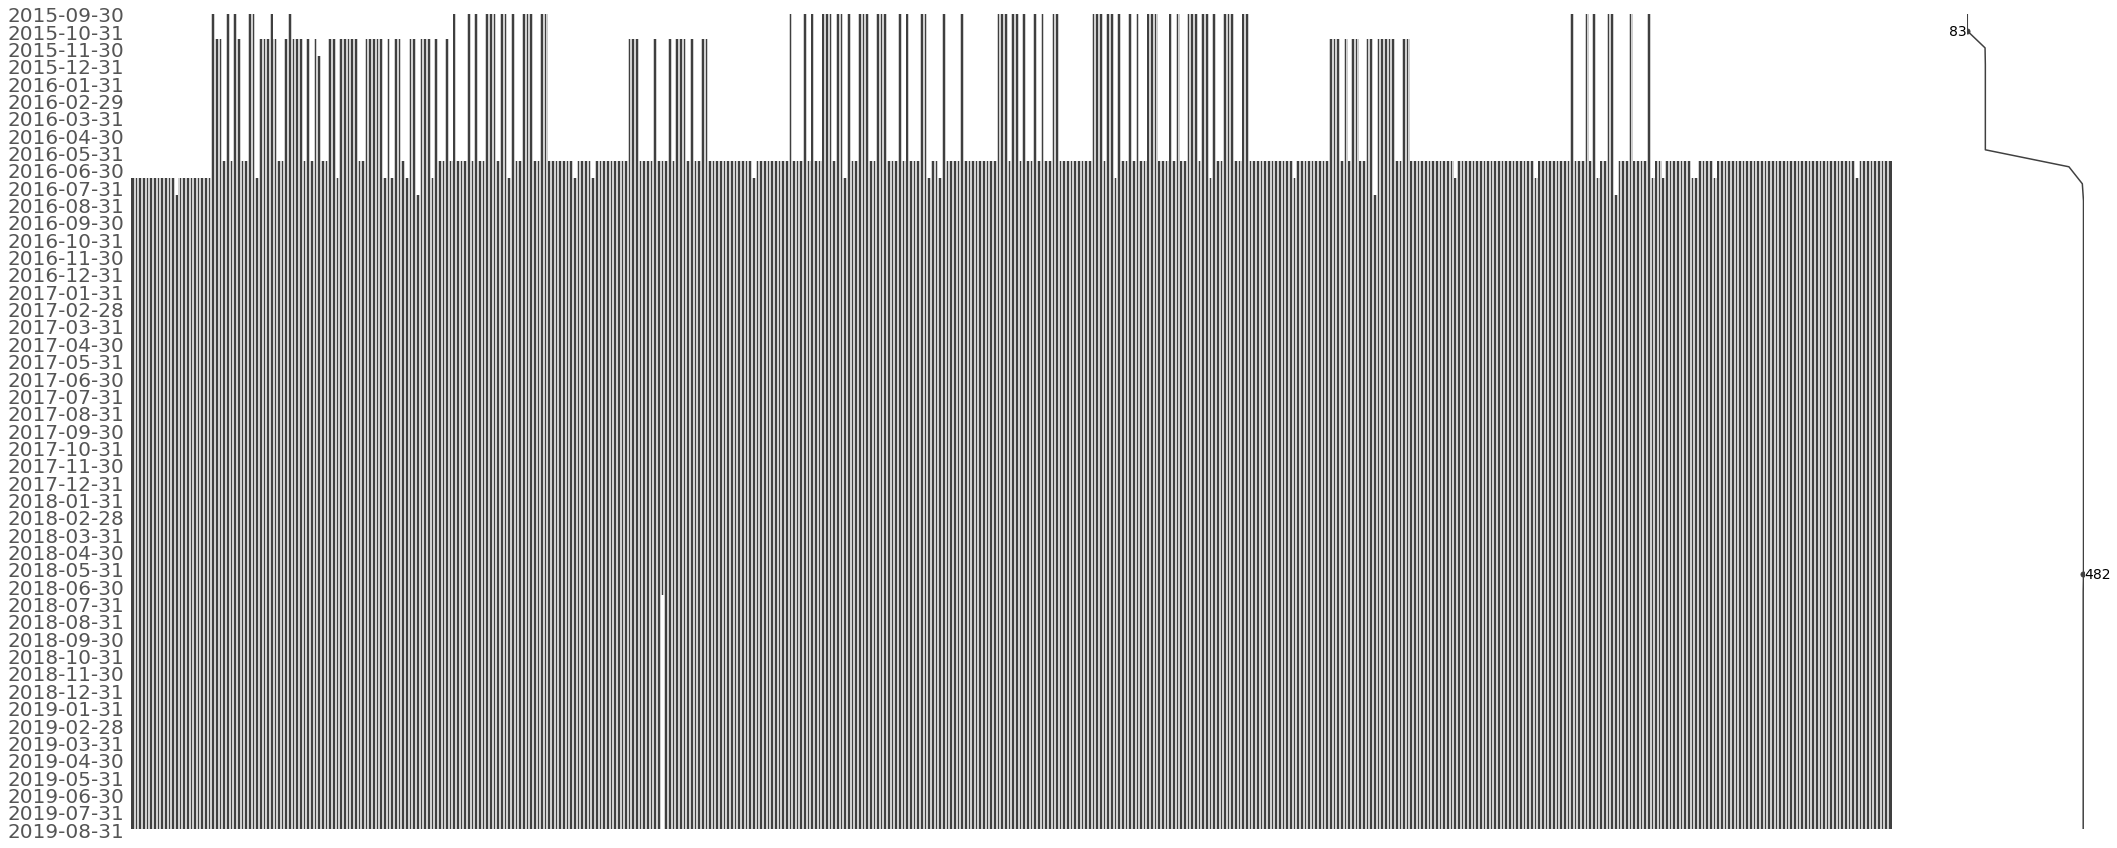

In [14]:
# Visualization of the missing values of the AdminStrata of the Yemen country of different products.
# Citation package: Bilogur, (2018). Missingno: a missing data visualization suite. Journal of Open Source Software, 3(22), 547, https://doi.org/10.21105/joss.00547
miss = msno.matrix(price.set_index(pd.period_range(price.index[0], price.index[-1], freq = "M")), freq = "M", figsize = (35, 15))

In [15]:
# Delete the columns that contains Nan values in the temporal range of the FCS and rCSI time-series.
price.dropna(inplace = True, axis = 1)

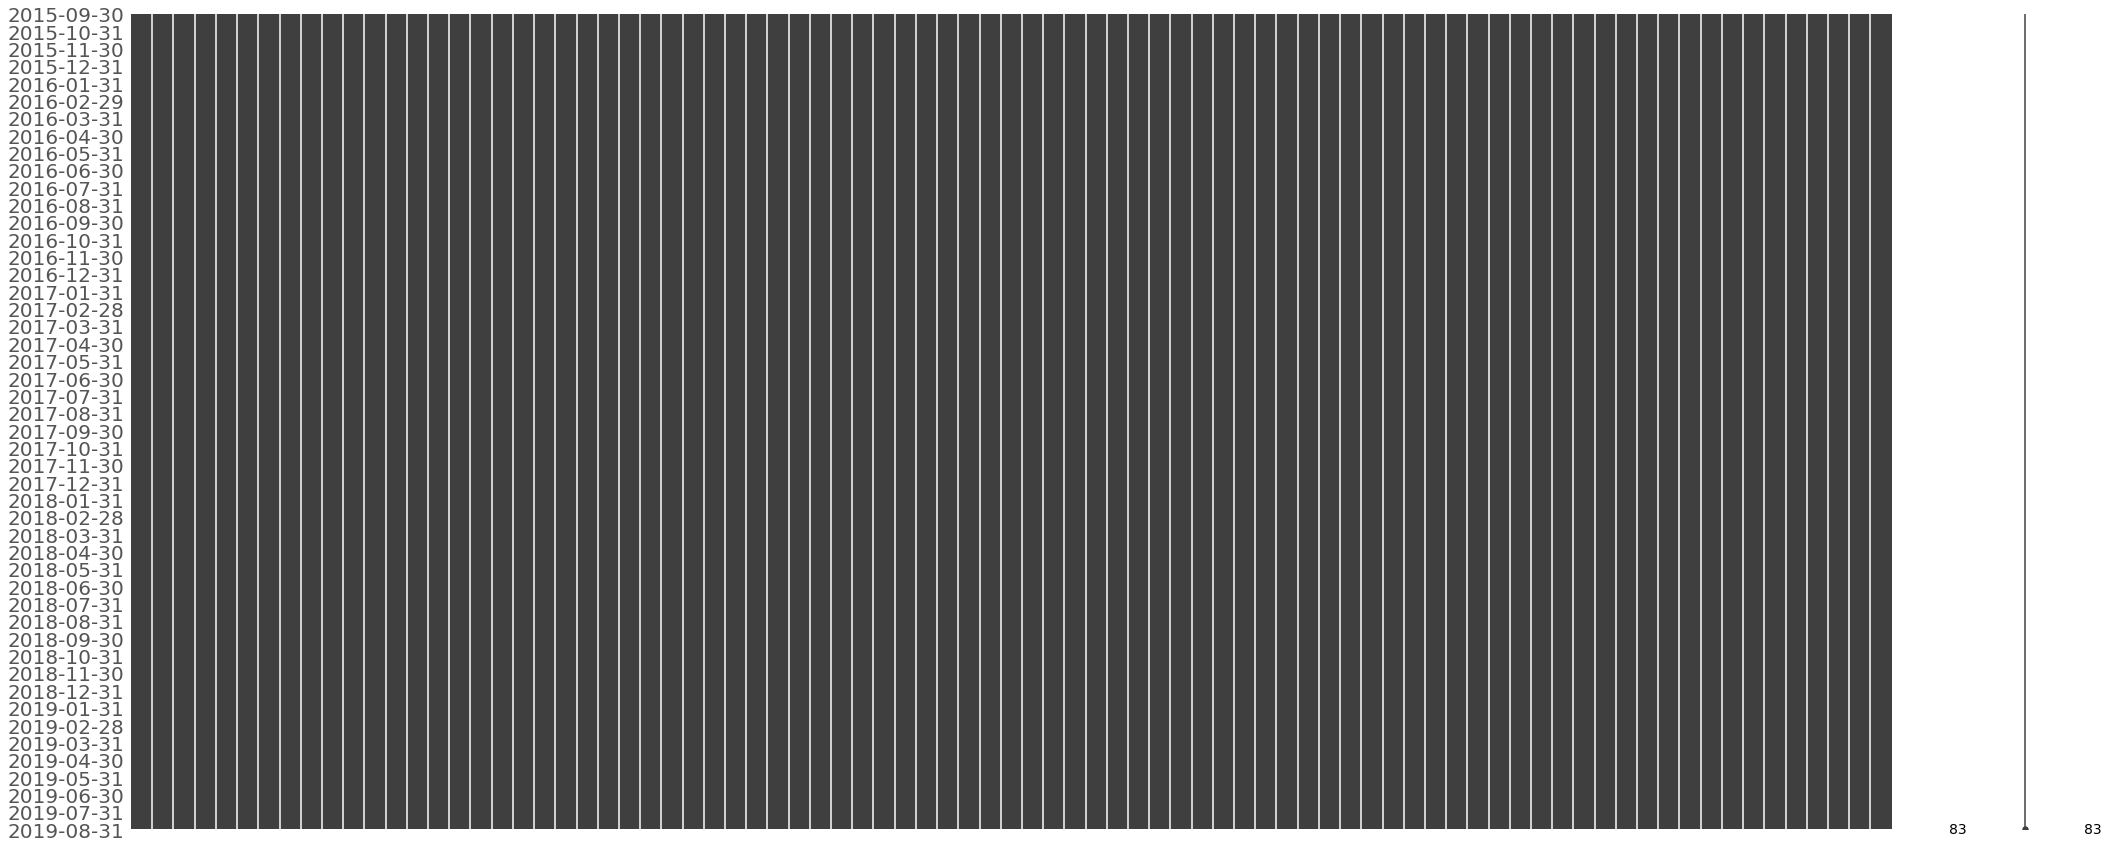

In [16]:
# Visualization of the missing values of the AdminStrata of the Yemen country of different products.
# Citation package: Bilogur, (2018). Missingno: a missing data visualization suite. Journal of Open Source Software, 3(22), 547, https://doi.org/10.21105/joss.00547
miss = msno.matrix(price.set_index(pd.period_range(price.index[0], price.index[-1], freq = "M")), freq = "M", figsize = (35, 15))

In [17]:
price.head()

AdminStrata,Beans (kidney red) - Retail_Aden,Fuel (diesel) - Retail_Aden,Fuel (petrol-gasoline) - Retail_Aden,Oil (vegetable) - Retail_Aden,Onions - Retail_Aden,Sugar - Retail_Aden,Wheat flour - Retail_Aden,Beans (kidney red) - Retail_Al Hudaydah,Fuel (diesel) - Retail_Al Hudaydah,Fuel (petrol-gasoline) - Retail_Al Hudaydah,...,Tomatoes - Retail_Hajjah,Wheat - Retail_Hajjah,Wheat flour - Retail_Hajjah,Beans (kidney red) - Retail_Sa'dah,Fuel (diesel) - Retail_Sa'dah,Fuel (petrol-gasoline) - Retail_Sa'dah,Oil (vegetable) - Retail_Sa'dah,Onions - Retail_Sa'dah,Sugar - Retail_Sa'dah,Wheat flour - Retail_Sa'dah
Datetime,,,,,,,,,,,,,,,,,,,,,
2015-09-30,550.0,350.0,350.0,460.00,300.0,300.0,200.0,600.0,700.0,700.0,...,355.0,117.0,170.0,600.0,600.0,500.0,552.00,400.0,250.0,190.0
2015-10-31,565.0,350.0,388.0,414.00,335.0,305.0,205.0,615.0,700.0,688.0,...,383.0,109.0,172.0,600.0,625.0,575.0,552.00,500.0,255.0,210.0
2015-11-30,533.0,369.0,429.0,414.00,383.0,297.0,206.0,545.0,681.0,656.0,...,350.0,100.0,181.5,545.0,650.0,608.0,552.00,470.0,257.0,220.0
2015-12-31,400.0,163.0,150.0,372.60,338.0,359.0,152.0,375.0,244.0,338.0,...,350.0,100.0,151.5,375.0,306.0,313.0,386.40,475.0,195.0,169.0
2016-01-31,400.0,150.0,150.0,318.32,200.0,289.0,155.0,321.0,261.0,360.0,...,288.0,99.0,136.0,325.0,276.0,304.0,334.88,348.0,228.0,148.0


In [18]:
price.to_excel("wfp_food_prices_yemen.xlsx", index = True)